### **Estimation of Parameters x0(position), q(shape-factor), z(depth), K(Amplitude Coefficient) from synthetic gravity anomaly data using MLPNN**

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random as rd
import os.path
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [3]:

# forward function
def forward(par, x_inp):
    var_x0 = par[0]
    var_q = par[1]
    var_z = par[2]
    var_k = par[3]

    var_ga = []
    for i in x_inp:
        var_up =  var_z
        var_down = ((i - var_x0)**2 + var_z**2) ** (var_q)
        var = var_k * (var_up / var_down)
        var_ga.append(var)
    
    return var_ga

In [4]:
# GA forward function
def GAfunc(x_inp, par):
    var_x0 = par[0]
    var_q = par[1]
    var_z = par[2]
    var_k = par[3]

    var_ga = []
    for i in x_inp:
        var_up =  var_z
        var_down = ((i - var_x0)**2 + var_z**2) ** (var_q)
        var = var_k * (var_up / var_down)
        var_ga.append(var)

    # === give noise for data (Gaussian Noise) 1
    std_noise = 1  # = %
    mean_noise = 0
    noise_data = np.random.normal(mean_noise, np.sqrt(std_noise), len(var_ga))
    var_ga_noise = var_ga + noise_data

    return var_ga, var_ga_noise, noise_data

For Sphere

number of data:  101


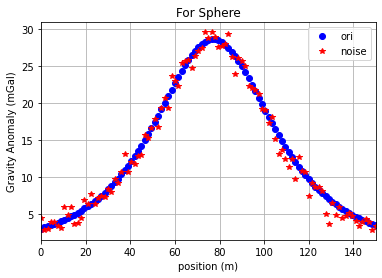

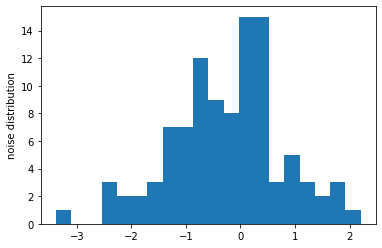

In [7]:
# === TEST FORWARD MODELING
x0 = 77.07  # m
q = 1.5
z = 41.81   # m
K = 50000

measure_loc = np.linspace(0, 150, 101)  # Location of measurement
print('number of data: ', len(measure_loc))
par_mod = [x0, q, z, K]      # model parameter of subsurface

get_GAData_sphere, get_GAData_noise_sphere, noise_from_maxData_sphere = GAfunc(measure_loc, par_mod)   # forward modeling test

plt.figure()
plt.plot(measure_loc, get_GAData_sphere, 'bo')
plt.plot(measure_loc, get_GAData_noise_sphere, 'r*')
plt.xlim([0, 150])
plt.xlabel('position (m)')
plt.ylabel('Gravity Anomaly (mGal)')
plt.title('For Sphere')
plt.legend(['ori', 'noise'])
plt.grid()

plt.figure()
plt.hist(noise_from_maxData_sphere,  bins=20)
plt.ylabel('noise distribution')
plt.show()



For Horizontal Cylinder

number of data:  101


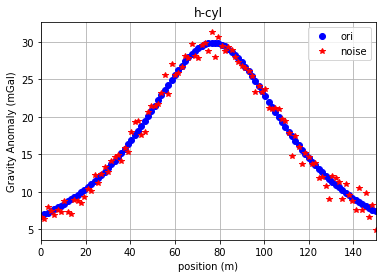

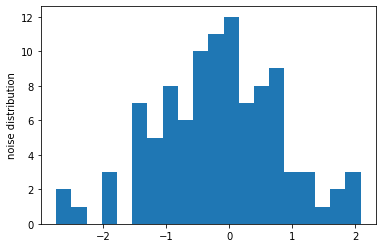

In [ ]:
# === TEST FORWARD MODELING
x0 = 77.07  # m
q = 1.0
z = 41.81   # m
K = 1250

measure_loc = np.linspace(0, 150, 101)  # Location of measurement
print('number of data: ', len(measure_loc))
par_mod = [x0, q, z, K]      # model parameter of subsurface

get_GAData_h_cyl, get_GAData_noise_h_cyl, noise_from_maxData_h_cyl = GAfunc(measure_loc, par_mod)   # forward modeling test

plt.figure()
plt.plot(measure_loc, get_GAData_h_cyl, 'bo')
plt.plot(measure_loc, get_GAData_noise_h_cyl, 'r*')
plt.xlim([0, 150])
plt.xlabel('position (m)')
plt.ylabel('Gravity Anomaly (mGal)')
plt.title('h-cyl')
plt.legend(['ori', 'noise'])
plt.grid()

plt.figure()
plt.hist(noise_from_maxData_h_cyl,  bins=20)
plt.ylabel('noise distribution')
plt.show()



For Vertical Cylinder

number of data:  101


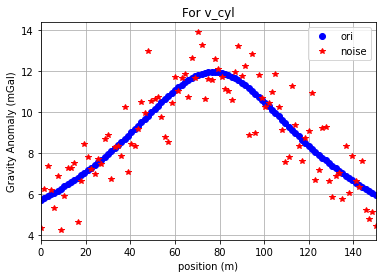

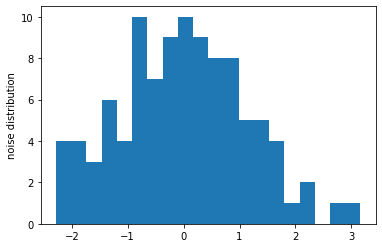

In [ ]:
# === TEST FORWARD MODELING
x0 = 77.07  # m
q = 0.5
z = 41.81   # m
K = 11.95

measure_loc = np.linspace(0, 150, 101)  # Location of measurement
print('number of data: ', len(measure_loc))
par_mod = [x0, q, z, K]      # model parameter of subsurface

get_GAData_v_cyl, get_GAData_noise_v_cyl, noise_from_maxData_v_cyl = GAfunc(measure_loc, par_mod)   # forward modeling test

plt.figure()
plt.plot(measure_loc, get_GAData_v_cyl, 'bo')
plt.plot(measure_loc, get_GAData_noise_v_cyl, 'r*')
plt.xlim([0, 150])
plt.xlabel('position (m)')
plt.ylabel('Gravity Anomaly (mGal)')
plt.title('For v_cyl')
plt.legend(['ori', 'noise'])
plt.grid()

plt.figure()
plt.hist(noise_from_maxData_v_cyl,  bins=20)
plt.ylabel('noise distribution')
plt.show()



Least Squares for sphere

In [ ]:
from scipy.optimize import least_squares as ls

# forward function
def forward_sphere(par, x_inp):
    var_x0 = par[0]
    var_q = 1.5
    var_z = par[2]
    var_k = par[3]

    var_ga = []
    for i in x_inp:
        var_up =  var_z
        var_down = ((i - var_x0)**2 + var_z**2) ** (var_q)
        var = var_k * (var_up / var_down)
        var_ga.append(var)
    
    return var_ga

# misfit equation
def pers(var_m, x_inp, y):
    return forward_sphere(var_m, x_inp) - y

In [ ]:
# initial model
x0_sphere = 70  # m
q_sphere = 1.5    # deg2rad
z_sphere = 40   # m
K_sphere = 40000
m0_sphere = np.array([x0_sphere, q_sphere, z_sphere, K_sphere])

position=np.linspace(0,151,101)

# Levenberg Marquardt (LM) algorithm
# Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
result = ls(pers, m0_sphere, method='lm', args=(position, get_GAData_noise_sphere))
x0_sphere_inv = result.x[0]
q_sphere_inv = result.x[1]
z_sphere_inv = result.x[2]
K_sphere_inv = result.x[3]
m_sphere_inv = np.array([x0_sphere_inv, q_sphere_inv, z_sphere_inv, K_sphere_inv])
GAData_calculation_sphere = forward_sphere(m_sphere_inv, position)

# real data without noise
x0_real_sphere = 77.07  # m
q_real_sphere = 1.5
z_real_sphere = 41.81   # m
K_real_sphere = 50000
m_real_sphere = np.array([x0_real_sphere, q_real_sphere, z_real_sphere, K_real_sphere])
GAData_real_sphere = forward_sphere(m_real_sphere, position)

Real Model x0: 77.070000 | q: 1.500000 | z: 41.810000 | K: 50000.000000
Inversion Model x0: 77.267960 | q: 1.500000 | z: 42.701106 | K: 51693.795079
Error: 0.000189


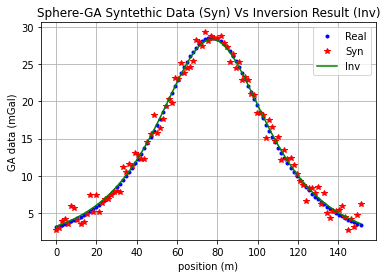

In [ ]:
# === Output
print('Real Model x0: %f | q: %f | z: %f | K: %f' % (x0_real_sphere, q_real_sphere, z_real_sphere, K_real_sphere))
print('Inversion Model x0: %f | q: %f | z: %f | K: %f' % (x0_sphere_inv, q_sphere_inv, z_sphere_inv, K_sphere_inv))
print('Error: %f' % (result.optimality * 100))

plt.plot(position, GAData_real_sphere, 'b.', label='Real')
plt.plot(position, get_GAData_noise_sphere, 'r*', label='Syn')
plt.plot(position, GAData_calculation_sphere, 'g', label='Inv')
plt.grid()
plt.xlabel('position (m)')
plt.ylabel('GA data (mGal)')
plt.legend()
plt.title('Sphere-GA Syntethic Data (Syn) Vs Inversion Result (Inv)')
plt.show()

Least squares for H_cyl

In [ ]:
from scipy.optimize import least_squares as ls

# forward function
def forward_h_cyl(par, x_inp):
    var_x0 = par[0]
    var_q = 1.0
    var_z = par[2]
    var_k = par[3]

    var_ga = []
    for i in x_inp:
        var_up =  var_z
        var_down = ((i - var_x0)**2 + var_z**2) ** (var_q)
        var = var_k * (var_up / var_down)
        var_ga.append(var)
    
    return var_ga

# misfit equation
def pers(var_m, x_inp, y):
    return forward_h_cyl(var_m, x_inp) - y

In [ ]:
# initial model
x0_h_cyl = 70  # m
q_h_cyl = 1.0    # deg2rad
z_h_cyl = 40   # m
K_h_cyl = 1000
m0_h_cyl = np.array([x0_h_cyl, q_h_cyl, z_h_cyl, K_h_cyl])

position=np.linspace(0,151,101)

# Levenberg Marquardt (LM) algorithm
# Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
result = ls(pers, m0_h_cyl, method='lm', args=(position, get_GAData_noise_h_cyl))
x0_h_cyl_inv = result.x[0]
q_h_cyl_inv = result.x[1]
z_h_cyl_inv = result.x[2]
K_h_cyl_inv = result.x[3]
m_h_cyl_inv = np.array([x0_h_cyl_inv, q_h_cyl_inv, z_h_cyl_inv, K_h_cyl_inv])
GAData_calculation_h_cyl = forward_h_cyl(m_h_cyl_inv, position)

# real data without noise
x0_real_h_cyl = 77.07  # m
q_real_h_cyl = 1.0
z_real_h_cyl = 41.81   # m
K_real_h_cyl = 1250
m_real_h_cyl = np.array([x0_real_h_cyl, q_real_h_cyl, z_real_h_cyl, K_real_h_cyl])
GAData_real_h_cyl = forward_h_cyl(m_real_h_cyl, position)

Real Model x0: 77.070000 | q: 1.000000 | z: 41.810000 | K: 1250.000000
Inversion Model x0: 77.314491 | q: 1.000000 | z: 41.413446 | K: 1240.592983
Error: 0.000159


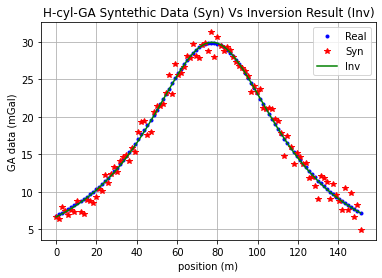

In [ ]:
# === Output
print('Real Model x0: %f | q: %f | z: %f | K: %f' % (x0_real_h_cyl, q_real_h_cyl, z_real_h_cyl, K_real_h_cyl))
print('Inversion Model x0: %f | q: %f | z: %f | K: %f' % (x0_h_cyl_inv, q_h_cyl_inv, z_h_cyl_inv, K_h_cyl_inv))
print('Error: %f' % (result.optimality * 100))

plt.plot(position, GAData_real_h_cyl, 'b.', label='Real')
plt.plot(position, get_GAData_noise_h_cyl, 'r*', label='Syn')
plt.plot(position, GAData_calculation_h_cyl, 'g', label='Inv')
plt.grid()
plt.xlabel('position (m)')
plt.ylabel('GA data (mGal)')
plt.legend()
plt.title('H-cyl-GA Syntethic Data (Syn) Vs Inversion Result (Inv)')
plt.show()

Least Squares For v_cyl

In [ ]:
from scipy.optimize import least_squares as ls

# forward function
def forward_v_cyl(par, x_inp):
    var_x0 = par[0]
    var_q = 0.5
    var_z = par[2]
    var_k = par[3]

    var_ga = []
    for i in x_inp:
        var_up =  var_z
        var_down = ((i - var_x0)**2 + var_z**2) ** (var_q)
        var = var_k * (var_up / var_down)
        var_ga.append(var)
    
    return var_ga

# misfit equation
def pers(var_m, x_inp, y):
    return forward_v_cyl(var_m, x_inp) - y

In [ ]:
# initial model
x0_v_cyl = 70  # m
q_v_cyl = 0.5    # deg2rad
z_v_cyl = 40   # m
K_v_cyl = 10
m0_v_cyl = np.array([x0_v_cyl, q_v_cyl, z_v_cyl, K_v_cyl])

position=np.linspace(0,151,101)

# Levenberg Marquardt (LM) algorithm
# Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
result = ls(pers, m0_v_cyl, method='lm', args=(position, get_GAData_noise_v_cyl))
x0_v_cyl_inv = result.x[0]
q_v_cyl_inv = result.x[1]
z_v_cyl_inv = result.x[2]
K_v_cyl_inv = result.x[3]
m_v_cyl_inv = np.array([x0_v_cyl_inv, q_v_cyl_inv, z_v_cyl_inv, K_v_cyl_inv])
GAData_calculation_v_cyl = forward_v_cyl(m_v_cyl_inv, position)

# real data without noise
x0_real_v_cyl = 77.07  # m
q_real_v_cyl = 0.5
z_real_v_cyl = 41.81   # m
K_real_v_cyl = 11.95
m_real_v_cyl = np.array([x0_real_v_cyl, q_real_v_cyl, z_real_v_cyl, K_real_v_cyl])
GAData_real_v_cyl = forward_v_cyl(m_real_v_cyl, position)

Real Model x0: 77.070000 | q: 0.500000 | z: 41.810000 | K: 11.950000
Inversion Model x0: 77.597330 | q: 0.500000 | z: 41.334103 | K: 12.033943
Error: 0.000045


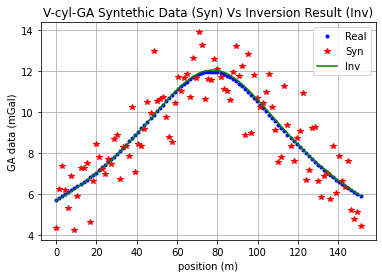

In [ ]:
# === Output
print('Real Model x0: %f | q: %f | z: %f | K: %f' % (x0_real_v_cyl, q_real_v_cyl, z_real_v_cyl, K_real_v_cyl))
print('Inversion Model x0: %f | q: %f | z: %f | K: %f' % (x0_v_cyl_inv, q_v_cyl_inv, z_v_cyl_inv, K_v_cyl_inv))
print('Error: %f' % (result.optimality * 100))

plt.plot(position, GAData_real_v_cyl, 'b.', label='Real')
plt.plot(position, get_GAData_noise_v_cyl, 'r*', label='Syn')
plt.plot(position, GAData_calculation_v_cyl, 'g', label='Inv')
plt.grid()
plt.xlabel('position (m)')
plt.ylabel('GA data (mGal)')
plt.legend()
plt.title('V-cyl-GA Syntethic Data (Syn) Vs Inversion Result (Inv)')
plt.show()

Sphere dataset

In [ ]:
# === MAKE SYNTHETIC DATASET
min_x0 = 50
max_x0 = 100
n_x0 = 20    # point
val_x0 = np.linspace(min_x0, max_x0, n_x0)


min_q = 1.5
max_q = 1.5
n_q = 1    # point
val_q = np.linspace(min_q, max_q, n_q)

min_z = 7
max_z = 75
n_z = 20    # point
val_z = np.linspace(min_z, max_z, n_z)

min_K = 1
max_K = 100000
n_K = 20     # point
val_K = np.linspace(min_K, max_K, n_K)

dataset_sphere = []
ndata = 10000
for it_dat in range(ndata):
    # x0s = min_x0 + (max_x0 - min_x0) * np.random.rand()
    x0s = rd.choice(val_x0)

    # qs = min_q + (max_q - min_q) * np.random.rand()
    qs = rd.choice(val_q)

    # hs = min_ht + (max_ht - min_ht) * np.random.rand()
    zs = rd.choice(val_z)

    # Ks = min_K + (max_K - min_K) * np.random.rand()
    Ks = rd.choice(val_K)

    par_mod = [x0s, qs, zs, Ks]

    measure_loc = np.linspace(0, 150, 101)     # Location of measurement
    get_GAData_sphere = GAfunc(measure_loc, par_mod)
    dataset_sphere.append((par_mod, get_GAData_sphere))  # [(input, output)]


par_mod

[52.631578947368425, 1.5, 67.84210526315789, 1.0]

H-cyl dataset

In [ ]:
# === MAKE SYNTHETIC DATASET
min_x0 = 50
max_x0 = 100
n_x0 = 20    # point
val_x0 = np.linspace(min_x0, max_x0, n_x0)


min_q = 1.0
max_q = 1.0
n_q = 1    # point
val_q = np.linspace(min_q, max_q, n_q)

min_z = 7
max_z = 75
n_z = 20    # point
val_z = np.linspace(min_z, max_z, n_z)

min_K = 1
max_K = 2500
n_K = 20     # point
val_K = np.linspace(min_K, max_K, n_K)

dataset_h_cyl = []
ndata = 10000
for it_dat in range(ndata):
    # x0s = min_x0 + (max_x0 - min_x0) * np.random.rand()
    x0s = rd.choice(val_x0)

    # qs = min_q + (max_q - min_q) * np.random.rand()
    qs = rd.choice(val_q)

    # hs = min_ht + (max_ht - min_ht) * np.random.rand()
    zs = rd.choice(val_z)

    # Ks = min_K + (max_K - min_K) * np.random.rand()
    Ks = rd.choice(val_K)

    par_mod = [x0s, qs, zs, Ks]

    measure_loc = np.linspace(0, 150, 101)     # Location of measurement
    get_GAData_h_cyl = GAfunc(measure_loc, par_mod)
    dataset_h_cyl.append((par_mod, get_GAData_h_cyl))  # [(input, output)]


par_mod

[100.0, 1.0, 57.10526315789474, 1184.7368421052631]

V-cyl dataset

In [ ]:
# === MAKE SYNTHETIC DATASET
min_x0 = 50
max_x0 = 100
n_x0 = 20    # point
val_x0 = np.linspace(min_x0, max_x0, n_x0)


min_q = 0.5
max_q = 0.5
n_q = 1    # point
val_q = np.linspace(min_q, max_q, n_q)

min_z = 7
max_z = 75
n_z = 20    # point
val_z = np.linspace(min_z, max_z, n_z)

min_K = 1
max_K = 150
n_K = 30     # point
val_K = np.linspace(min_K, max_K, n_K)

dataset_v_cyl = []
ndata = 10000
for it_dat in range(ndata):
    # x0s = min_x0 + (max_x0 - min_x0) * np.random.rand()
    x0s = rd.choice(val_x0)

    # qs = min_q + (max_q - min_q) * np.random.rand()
    qs = rd.choice(val_q)

    # hs = min_ht + (max_ht - min_ht) * np.random.rand()
    zs = rd.choice(val_z)

    # Ks = min_K + (max_K - min_K) * np.random.rand()
    Ks = rd.choice(val_K)

    par_mod = [x0s, qs, zs, Ks]

    measure_loc = np.linspace(0, 150, 101)     # Location of measurement
    get_GAData_v_cyl = GAfunc(measure_loc, par_mod)
    dataset_v_cyl.append((par_mod, get_GAData_v_cyl))  # [(input, output)]


par_mod

[57.89473684210526, 0.5, 17.736842105263158, 88.3448275862069]

In [ ]:


dataset=dataset_h_cyl+dataset_sphere+dataset_v_cyl
rd.shuffle(dataset)


train data:  29700


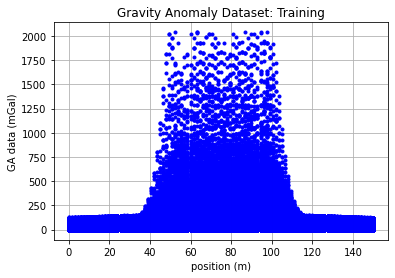

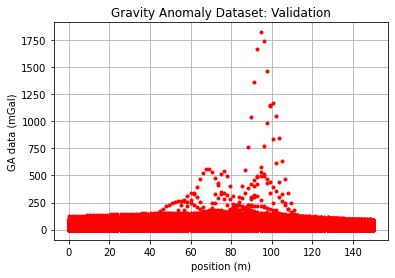

In [ ]:
ndata, ncol = np.shape(dataset)
itrain = int(0.99 * ndata)
print('train data: ', itrain)
measure_loc = np.linspace(0, 150, 101)
X_train = []
X_valid = []
y_train = []
y_valid = []
it_split = 1

# getGAData contains GAdata, GAdata_noise, and noise_data
for param, getGAData in dataset:
    # split data for training and validation
    if it_split <= itrain:
        X_train.append(getGAData[1])  # GAdata_noise
        y_train.append(param)
    else:
        X_valid.append(getGAData[1])   # GAdata_noise
        y_valid.append(param)
    it_split = it_split + 1

for i in np.arange(itrain):
    plt.plot(measure_loc, X_train[i], 'b.')

plt.xlabel('position (m)')
plt.ylabel('GA data (mGal)')
plt.title('Gravity Anomaly Dataset: Training')
plt.grid()
plt.show()

for i in np.arange(ndata-itrain):
    plt.plot(measure_loc, X_valid[i], 'r.')

plt.xlabel('position (m)')
plt.ylabel('GA data (mGal)')
plt.title('Gravity Anomaly Dataset: Validation')
plt.grid()
plt.show()

In [ ]:
# Training data
X_train = np.array(X_train)
y_train = np.array(y_train)

#Test data
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
position=np.linspace(0,150,101)

#sphere
test_sphere=[77.07,1.5,41.81,50000]
result_sphere=forward(test_sphere,position)
result_sphere=np.reshape(result_sphere, (-1, 1))
result_sphere_trans=result_sphere.transpose()
result_sphere_trans_scaled = scaler.transform(result_sphere_trans)

#h-cyl
test_h_cyl=[77.07,1.0,41.81,1250]
result_h_cyl=forward(test_h_cyl,position)
result_h_cyl=np.reshape(result_h_cyl, (-1, 1))
result_h_cyl_trans=result_h_cyl.transpose()
result_h_cyl_trans_scaled = scaler.transform(result_h_cyl_trans)

#v-cyl
test_v_cyl=[77.07,0.5,41.81,11.95]
result_v_cyl=forward(test_v_cyl,position)
result_v_cyl=np.reshape(result_v_cyl, (-1, 1))
result_v_cyl_trans=result_v_cyl.transpose()
result_v_cyl_trans_scaled = scaler.transform(result_v_cyl_trans)

y_train_scaled = scaler.fit_transform(y_train)
y_valid_scaled = scaler.transform(y_valid)


# size X_train and y_train
print('size X_train: ', X_train.shape)
print('size y_train: ', y_train.shape)

size X_train:  (29700, 101)
size y_train:  (29700, 4)


In [ ]:
input_shape = (101,)
print(f'Feature shape: {input_shape}')

Feature shape: (101,)


In [ ]:
model= Sequential()
model.add(Dense(128, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(4))

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=64, verbose=1, validation_split=0.1,callbacks=[callback])

Epoch 1/50
418/418 [==============================] - 1s 3ms/step - loss: 0.4165 - mean_squared_error: 0.4225 - val_loss: 0.3352 - val_mean_squared_error: 0.3064
Epoch 2/50
418/418 [==============================] - 1s 2ms/step - loss: 0.3067 - mean_squared_error: 0.2641 - val_loss: 0.2734 - val_mean_squared_error: 0.2207
Epoch 3/50
418/418 [==============================] - 1s 2ms/step - loss: 0.2642 - mean_squared_error: 0.2089 - val_loss: 0.2325 - val_mean_squared_error: 0.1602
Epoch 4/50
418/418 [==============================] - 1s 2ms/step - loss: 0.2346 - mean_squared_error: 0.1740 - val_loss: 0.2384 - val_mean_squared_error: 0.1773
Epoch 5/50
418/418 [==============================] - 1s 2ms/step - loss: 0.2209 - mean_squared_error: 0.1587 - val_loss: 0.2159 - val_mean_squared_error: 0.1504
Epoch 6/50
418/418 [==============================] - 1s 2ms/step - loss: 0.2084 - mean_squared_error: 0.1469 - val_loss: 0.1954 - val_mean_squared_error: 0.1313
Epoch 7/50
418/418 [========

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_valid_scaled, y_valid_scaled, batch_size=10)
print("test loss, test acc:", results)

Evaluate on test data
30/30 [==============================] - 0s 1ms/step - loss: 0.1636 - mean_squared_error: 0.1574
test loss, test acc: [0.16358207166194916, 0.157420352101326]


In [ ]:
predictions_sphere = model.predict(result_sphere_trans_scaled)
predictions_inverse_sphere=scaler.inverse_transform(predictions_sphere)
final_sphere=predictions_inverse_sphere.ravel()
final_sphere

array([7.6739052e+01, 1.5073946e+00, 4.2300987e+01, 5.2125074e+04],
      dtype=float32)

Real Model x0: 77.070000 | q: 1.500000 | z: 41.810000 | K: 50000.000000
Inversion Model x0: 77.793896 | q: 1.500000 | z: 42.083420 | K: 50258.709023
MLPNN Model x0: 76.739052 | q: 1.507395 | z: 42.300987 | K: 52125.074219


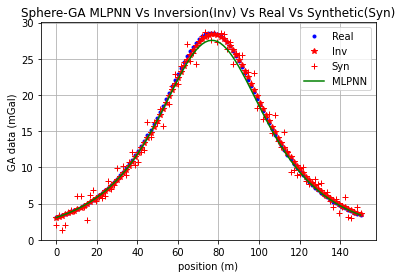

In [ ]:
GAData_mlnn_sphere=forward(final_sphere, position)
print('Real Model x0: %f | q: %f | z: %f | K: %f' % (x0_real_sphere, q_real_sphere, z_real_sphere, K_real_sphere))
print('Inversion Model x0: %f | q: %f | z: %f | K: %f' % (x0_sphere_inv, q_sphere_inv, z_sphere_inv, K_sphere_inv))
print('MLPNN Model x0: %f | q: %f | z: %f | K: %f' % (final_sphere[0], final_sphere[1], final_sphere[2], final_sphere[3]))

plt.plot(position, GAData_real_sphere, 'b.', label='Real')
plt.plot(position, GAData_calculation_sphere, 'r*', label='Inv')
plt.plot(position, get_GAData_noise_sphere, 'r+', label='Syn')
plt.plot(position, GAData_mlnn_sphere, 'g', label='MLPNN')
plt.grid()
plt.xlabel('position (m)')
plt.ylabel('GA data (mGal)')
plt.legend()
plt.title('Sphere-GA MLPNN Vs Inversion(Inv) Vs Real Vs Synthetic(Syn)')
plt.show()

In [ ]:
predictions_h_cyl = model.predict(result_h_cyl_trans_scaled)
predictions_inverse_h_cyl=scaler.inverse_transform(predictions_h_cyl)
final_h_cyl=predictions_inverse_h_cyl.ravel()
final_h_cyl

array([7.6957893e+01, 9.9594361e-01, 4.3299152e+01, 1.7068068e+03],
      dtype=float32)

Real Model x0: 77.070000 | q: 1.000000 | z: 41.810000 | K: 1250.000000
Inversion Model x0: 77.314491 | q: 1.000000 | z: 41.413446 | K: 1240.592983
MLPNN Model x0: 76.957893 | q: 0.995944 | z: 43.299152 | K: 1706.806763


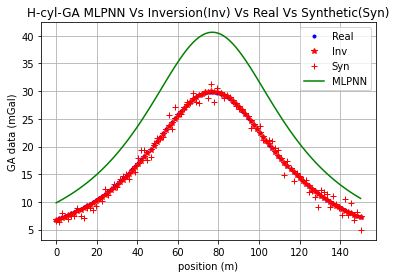

In [ ]:
GAData_mlnn_h_cyl=forward(final_h_cyl, position)
print('Real Model x0: %f | q: %f | z: %f | K: %f' % (x0_real_h_cyl, q_real_h_cyl, z_real_h_cyl, K_real_h_cyl))
print('Inversion Model x0: %f | q: %f | z: %f | K: %f' % (x0_h_cyl_inv, q_h_cyl_inv, z_h_cyl_inv, K_h_cyl_inv))
print('MLPNN Model x0: %f | q: %f | z: %f | K: %f' % (final_h_cyl[0], final_h_cyl[1], final_h_cyl[2], final_h_cyl[3]))

plt.plot(position, GAData_real_h_cyl, 'b.', label='Real')
plt.plot(position, GAData_calculation_h_cyl, 'r*', label='Inv')
plt.plot(position, get_GAData_noise_h_cyl, 'r+', label='Syn')
plt.plot(position, GAData_mlnn_h_cyl, 'g', label='MLPNN')
plt.grid()
plt.xlabel('position (m)')
plt.ylabel('GA data (mGal)')
plt.legend()
plt.title('H-cyl-GA MLPNN Vs Inversion(Inv) Vs Real Vs Synthetic(Syn)')
plt.show()

In [ ]:
predictions_v_cyl = model.predict(result_v_cyl_trans_scaled)
predictions_inverse_v_cyl=scaler.inverse_transform(predictions_v_cyl)
final_v_cyl=predictions_inverse_v_cyl.ravel()
final_v_cyl

array([ 77.1812   ,   0.8562463,  64.186165 , 798.72375  ], dtype=float32)

Real Model x0: 77.070000 | q: 0.500000 | z: 41.810000 | K: 11.950000
Inversion Model x0: 77.597330 | q: 0.500000 | z: 41.334103 | K: 12.033943
MLPNN Model x0: 77.181198 | q: 0.856246 | z: 64.186165 | K: 798.723755


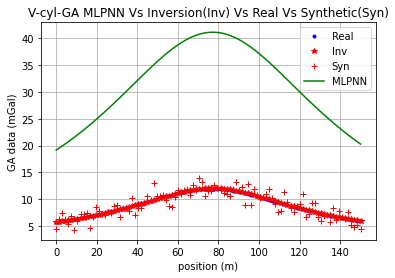

In [ ]:
GAData_mlnn_v_cyl=forward(final_v_cyl, position)
print('Real Model x0: %f | q: %f | z: %f | K: %f' % (x0_real_v_cyl, q_real_v_cyl, z_real_v_cyl, K_real_v_cyl))
print('Inversion Model x0: %f | q: %f | z: %f | K: %f' % (x0_v_cyl_inv, q_v_cyl_inv, z_v_cyl_inv, K_v_cyl_inv))
print('MLPNN Model x0: %f | q: %f | z: %f | K: %f' % (final_v_cyl[0], final_v_cyl[1], final_v_cyl[2], final_v_cyl[3]))

plt.plot(position, GAData_real_v_cyl, 'b.', label='Real')
plt.plot(position, GAData_calculation_v_cyl, 'r*', label='Inv')
plt.plot(position, get_GAData_noise_v_cyl, 'r+', label='Syn')
plt.plot(position, GAData_mlnn_v_cyl, 'g', label='MLPNN')
plt.grid()
plt.xlabel('position (m)')
plt.ylabel('GA data (mGal)')
plt.legend()
plt.title('V-cyl-GA MLPNN Vs Inversion(Inv) Vs Real Vs Synthetic(Syn)')
plt.show()